In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
from pprint import pprint
from copy import deepcopy
from typing import Iterable, Callable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

In [3]:
from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, cal_curve, accuracy
from probcalkge import get_cls_name

In [4]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error, ece]
    )

In [6]:
exp.load_trained_kges('../saved_models/trained_kges')

Loaded trained KG embedding models.


In [7]:
exp_res = exp.run_with_trained_kges()

training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on DBpedia50 ...
training various calibrators for ComplEx on DBpedia50 ...
training various calibrators for DistMult on DBpedia50 ...
training various calibrators for HolE on DBpedia50 ...
training various calibrators for TransE on Kinship ...
training various calibrators for ComplEx on Kinship ...
training various cali

In [8]:
from sklearn.calibration import CalibrationDisplay


def plot_ds_kge_cals(data, kge, cals, ax=None):
    ax = plt.axes() if ax == None else ax

    for cal in cals:
        scores = kge.predict(data.X_test)
        probs = cal.predict(expit(scores))
        CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=cal.name)
    
    ax.set_title(f'{data.name}-{kge.name}')
    ax.legend()
    ax.get_legend().remove()
    ax.set(xlabel=None)
    ax.set(ylabel=None)
        

Text(0.02, 0.5, 'Fraction of Positives')

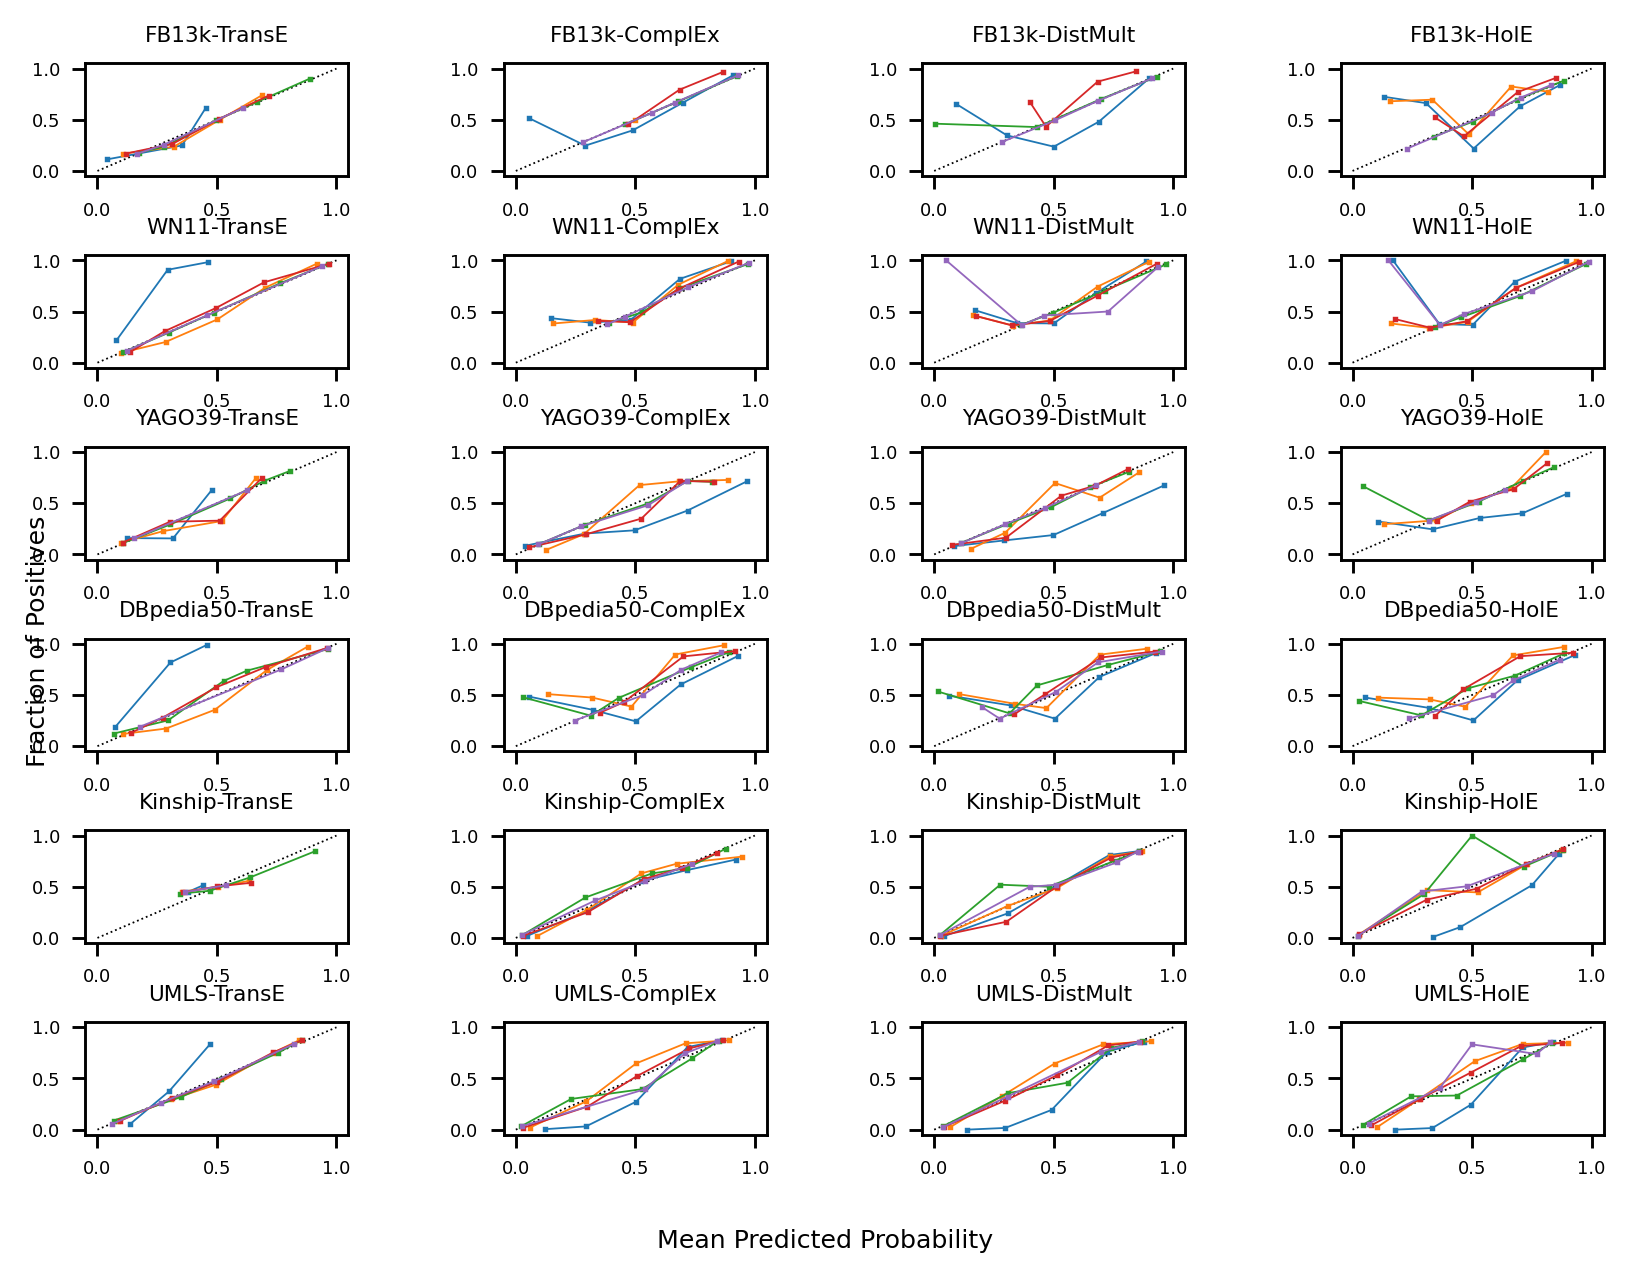

In [9]:
plt.rc('figure', dpi=260) # default for me was 75
plt.rc('figure', titlesize=7)
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=6)
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)
plt.rc('legend', fontsize=8)
plt.rc('lines', linewidth=0.5)
plt.rc('lines', markersize=0.5)

fig, axes = plt.subplots(6, 4)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
fig.tight_layout(h_pad=0.8)
for i, data in enumerate(exp.datasets):
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        cals = exp.trained_cals[data.name][kge.name].values()
        plot_ds_kge_cals(data, kge, cals, axes[i][j])
fig.supxlabel('Mean Predicted Probability')
fig.supylabel('Fraction of Positives')
# plt.legend()

In [55]:
def plot_metrics(metric):
    plt.rc('figure', dpi=75) # default for me was 75
    # plt.rc('figure', titlesize=26)
    plt.rc('axes', labelsize=5)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=9)
    plt.rc('ytick', labelsize=7.5)
    plt.rc('legend', fontsize=9)
    plt.rc('lines', linewidth=2)
    plt.rc('lines', markersize=2)
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
    # fig, axes = plt.subplots(1, 6, sharey=True)
    # fig.set_size_inches(18.5, 3.0, forward=True)
    
    fig.supylabel(metric.__name__, fontsize=16)
    # fig.tight_layout(w_pad=0.008, h_pad=0.008)
    fig.subplots_adjust(left=0.12)

    res = {}
    for i, data in enumerate(exp.datasets):
        res[data.name] = {}
        for j, kge in enumerate(exp.trained_kges[data.name].values()):
            res[data.name][kge.name] = []
            for cal in  exp.trained_cals[data.name][kge.name].values():
                scores = kge.predict(data.X_test)
                probs = cal.predict(expit(scores))
                if get_cls_name(kge) == 'TransE' and cal.name == 'UncalCalibrator':
                    probs = probs * 2 # expit probs of TransE [0, 0.5] -> [0, 1] 
                res[data.name][kge.name].append(metric(data.y_test, probs))


    for i, k in enumerate(res.keys()):
        ax = axes[i // 3][i % 3]
        # ax = axes[i]
        ax = pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin', ]).T.round(3).plot(kind='bar', ax=ax, width=0.85)
        ax.set_xticklabels(['TransE', 'ComplEx', 'DistMult', 'HoLE'], rotation=45)
        ax.set_title(f'{k}')
        # if k != 'FB13k':
        ax.legend()
        ax.get_legend().remove()
    fig.legend(['Uncal', 'Platt', 'Isot', 'beta', 'histbin', ])


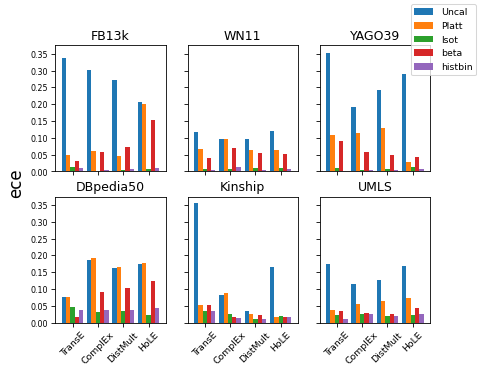

In [56]:
plot_metrics(ece)

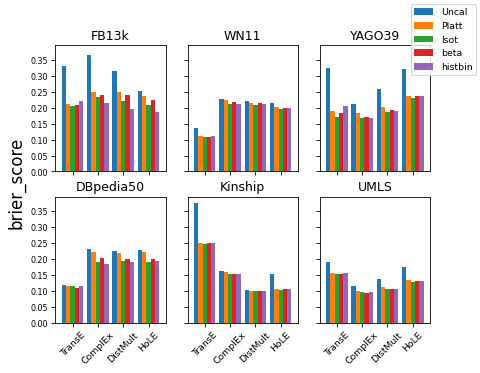

In [57]:
plot_metrics(brier_score)

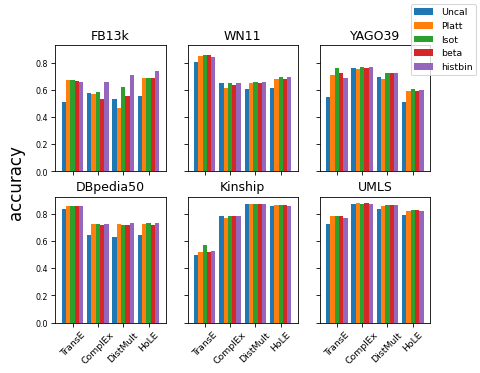

In [58]:
plot_metrics(accuracy)

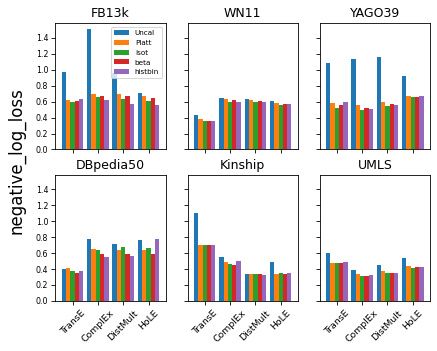

In [47]:
plot_metrics(negative_log_loss)

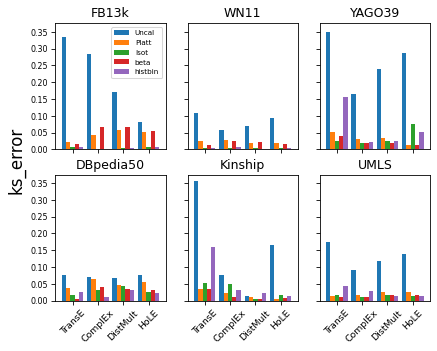

In [48]:
plot_metrics(ks_error)

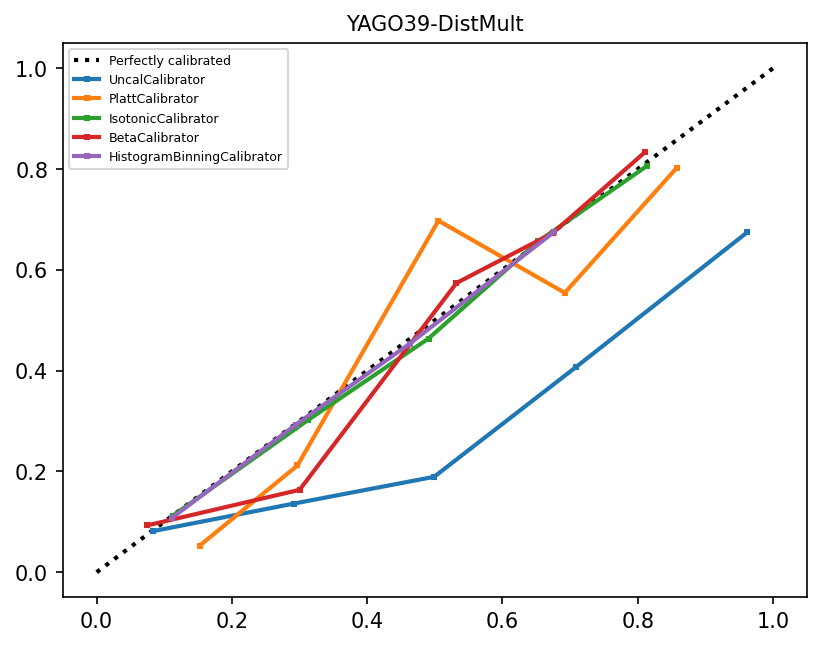

In [49]:
plt.rcParams['figure.dpi'] = 150 # default for me was 75
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=6)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

data = exp.datasets[2]
kge = exp.trained_kges[data.name]['DistMult']
c = exp.trained_cals[data.name][kge.name].values()
plot_ds_kge_cals(data, kge, c)
plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score
def per_rel_threshold(model, data):
    scores = model.predict(data.X_test)
    val_scores = model.predict(data.X_valid)
    thresholds = {r: np.median(np.sort(val_scores[data.X_valid[:, 1] == r])) for r in np.unique(data.X_valid[:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(data.X_test[:, 1])
    per_relation_acc = accuracy_score(data.y_test, scores > thresholds_test)
    return per_relation_acc, thresholds

for data in exp.datasets:
    for kge in exp.trained_kges[data.name].values():
        try:
            print(f'{data.name} {kge.name}')
            print('    ', per_rel_threshold(kge, data)[0])
        except TypeError as err:
            print(err)

0.5181564245810056


(array([  2.,   6.,  41., 238., 307., 316., 439., 405., 313.,  81.]),
 array([-5.144771  , -4.63092   , -4.1170683 , -3.603217  , -3.0893655 ,
        -2.575514  , -2.0616627 , -1.5478113 , -1.0339599 , -0.5201085 ,
        -0.00625711], dtype=float32),
 <BarContainer object of 10 artists>)

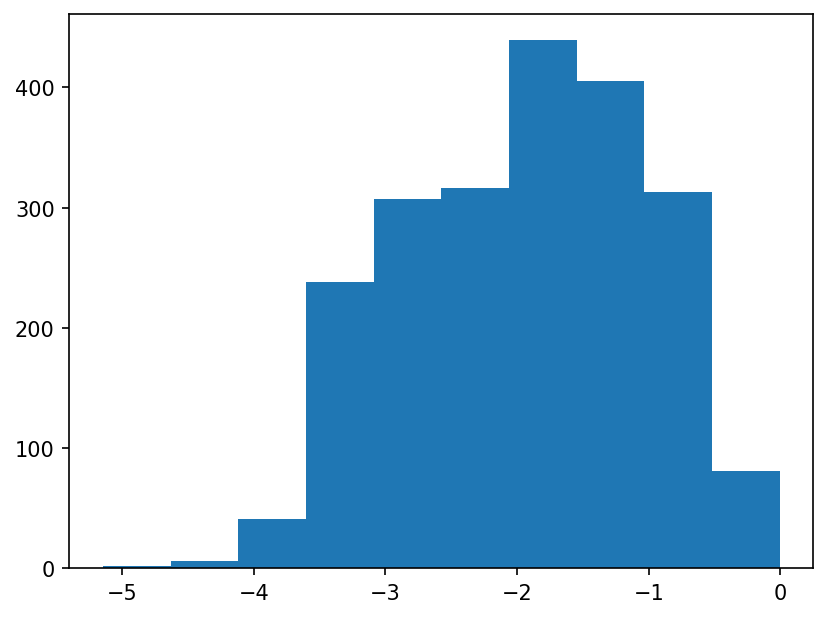

In [ ]:
te_wn = exp.trained_kges['UMLS']['TransE']
scores = te_wn.predict(ds.kinship.X_test)
probs = expit(scores) * 2
print(accuracy_score(ds.kinship.y_test, probs>0.5))
plt.hist(probs)